## NLP Exercise

### We are given a collection of documents stored as text files. Our task is to group the documents based on how similar they look like.  


In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids

import gensim.downloader as api
from gensim.models import KeyedVectors


### Step 1: Gathering the data and making it all lowercase

In [2]:
folder_path = r"C:\Users\konch\Downloads\Data Scientist Challenge (1)\Data Scientist Challenge\data\nlp"
documents = []

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
            text_data = text_data.lower()
            documents.append(text_data)

df = pd.DataFrame(documents, columns=["Text"])

In [3]:
df.head()

,Text
0,the cat's tail flicked back and forth in antic...
1,the cat's piercing yellow eyes narrowed as it ...
2,a vibrant orange coat and piercing blue eyes m...
3,"the sun slowly sank below the horizon, paintin..."
4,"the waves rippled gently against the shore, as..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    247 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB


### Step 2: Preprocessing

#### First Cleanup 

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\r', '', text)
    text = re.sub('â', '', text)
    text = re.sub('@', '', text)
    text = re.sub('', '', text)
    text = re.sub('#', '', text)
    return text

In [6]:
df['Text'] = df['Text'].apply(clean_text)
df.head()

,Text
0,the cats tail flicked back and forth in antici...
1,the cats piercing yellow eyes narrowed as it s...
2,a vibrant orange coat and piercing blue eyes m...
3,the sun slowly sank below the horizon painting...
4,the waves rippled gently against the shore as ...


#### Removing Stopwords 

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['Text'] = df['Text'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\konch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text
0,cats tail flicked back forth anticipation watc...
1,cats piercing yellow eyes narrowed spotted jui...
2,vibrant orange coat piercing blue eyes marked ...
3,sun slowly sank horizon painting sky breathtak...
4,waves rippled gently shore sun began descent s...


#### Setting up a Lemmatizer - Tokenizer 

In [8]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\konch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\konch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
lemmatizer = WordNetLemmatizer()
def tokenize_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

### Step 3: Vectorization

#### For Vectorization we will use the TF-IDF and Word2Vec techniques

##### TF-IDF:

In [10]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_lemmatize,max_df=0.95, min_df=4, norm="l2")
tfidf_matrix = vectorizer.fit_transform(df['Text'])

##### Word2Vec:

In [11]:
df['Tokens'] = df['Text'].apply(tokenize_lemmatize)

In [12]:
word2vec_model = Word2Vec(sentences=df['Tokens'], vector_size=100, window=3, min_count=1, workers=8)

In [13]:
#word2vec_model = api.load('word2vec-google-news-300')

#It took a lot of time to download and the model takes 1662 MB of memory so it's just left here as an alternative


In [14]:
document_embeddings = [np.mean([word2vec_model.wv[token] for token in tokens], axis=0) for tokens in df['Tokens']]

### Step 4: Clustering

#### We will use K-means and K-medoids as clustering methods

#### But first we will use elbow and silhouette methods to determine how many clusters to divide the data into for K-means

#### K-Means & Word2Vec

In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Warning was about an environment variable. I set it in the recommended value and warning persisted and that's why this chunk of code is here.


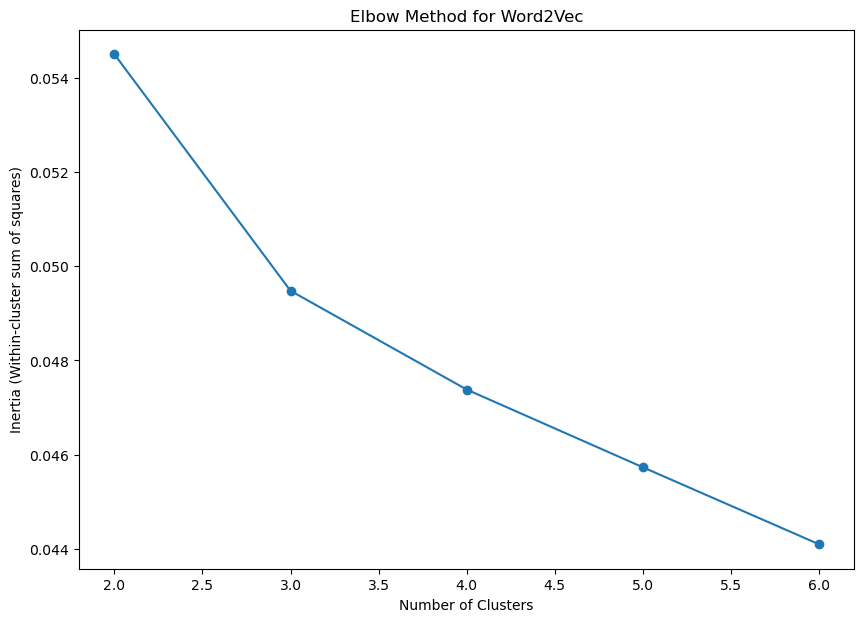

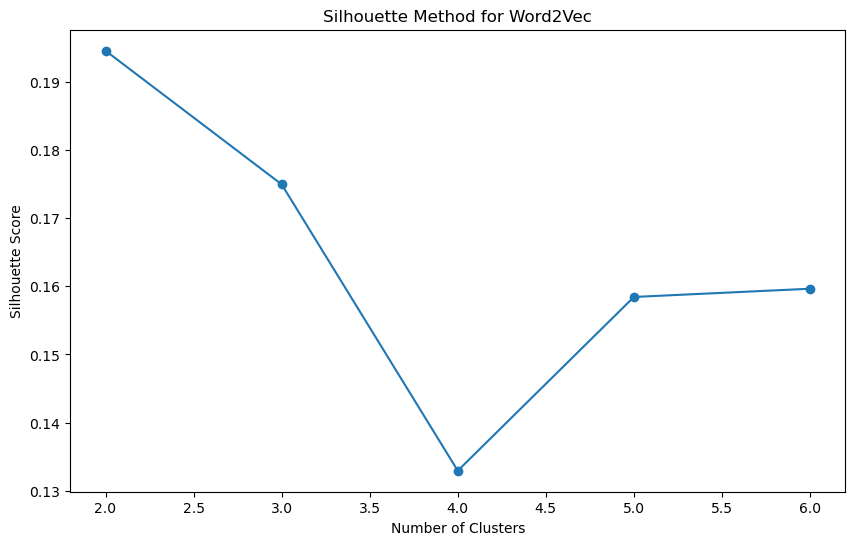

In [16]:
# Elbow method for Word2Vec
inertia_values_word2vec = []
num_clusters_range = range(2, 7)
for num_clusters in num_clusters_range:
    kmeans_word2vec = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_word2vec.fit(document_embeddings)
    inertia_values_word2vec.append(kmeans_word2vec.inertia_)

#Elbow curve for Word2Vec
plt.figure(figsize=(10, 7))
plt.plot(num_clusters_range, inertia_values_word2vec, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Word2Vec')
plt.show()

silhouette_scores_word2vec = []
for num_clusters in num_clusters_range:
    kmeans_word2vec = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels_word2vec = kmeans_word2vec.fit_predict(document_embeddings)
    silhouette_scores_word2vec.append(silhouette_score(document_embeddings, cluster_labels_word2vec))

# Plotting the Silhouette scores for Word2Vec
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores_word2vec, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Word2Vec')
plt.show()

best_num_clusters_kmeans_word2vec = np.argmax(silhouette_scores_word2vec) + 2
best_silhouette_score_kmeans_word2vec = silhouette_scores_word2vec[np.argmax(silhouette_scores_word2vec)]



#### Kmeans & TF-IDF

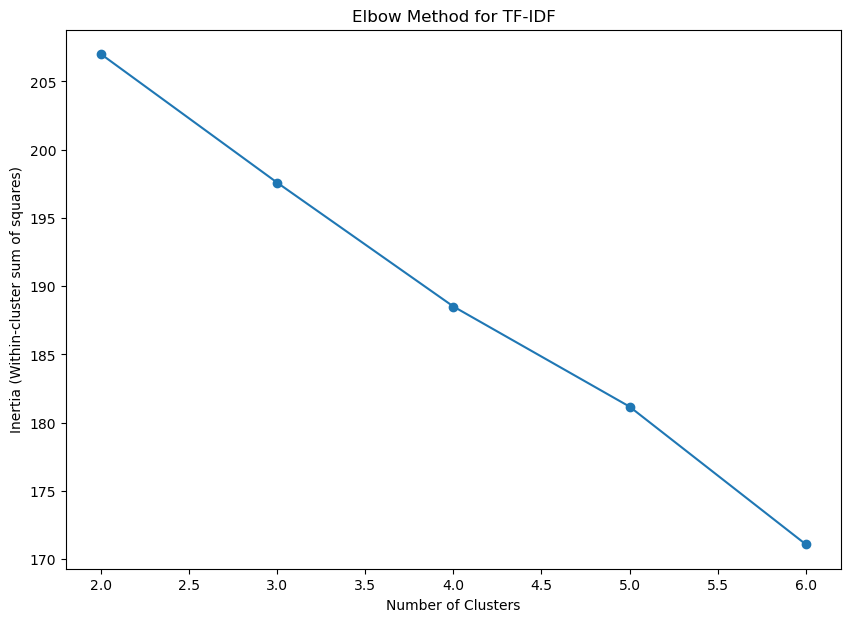

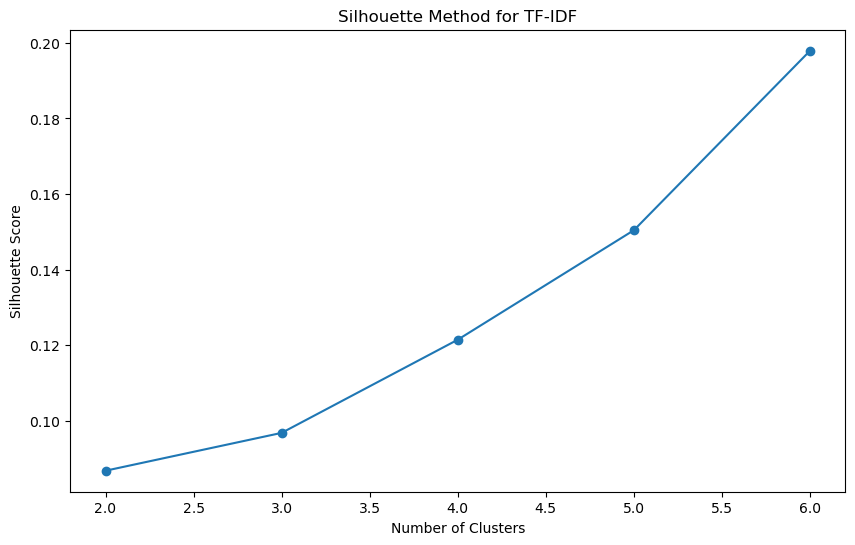

In [17]:
# Elbow Method for TF-IDF
inertia_values_tfidf = []
num_clusters_range = range(2, 7)
for num_clusters in num_clusters_range:
    kmeans_tfidf = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_tfidf.fit(tfidf_matrix)
    inertia_values_tfidf.append(kmeans_tfidf.inertia_)

#Elbow curve for TF-IDF
plt.figure(figsize=(10, 7))
plt.plot(num_clusters_range, inertia_values_tfidf, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for TF-IDF')
plt.show()


silhouette_scores_tfidf = []
for num_clusters in num_clusters_range:
    kmeans_tfidf = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels_tfidf = kmeans_tfidf.fit_predict(tfidf_matrix)
    silhouette_scores_tfidf.append(silhouette_score(tfidf_matrix, cluster_labels_tfidf))

# Plotting the Silhouette scores for TF-IDF
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores_tfidf, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for TF-IDF')
plt.show()

best_num_clusters_kmeans_tfidf = np.argmax(silhouette_scores_tfidf) + 2
best_silhouette_score_kmeans_tfidf = silhouette_scores_tfidf[np.argmax(silhouette_scores_tfidf)]




#### Word2Vec & K-medoids

Note: We used manhattan distance as the distance metric for K-medoids because default metric produced only negative silhouette score values for TF-IDF

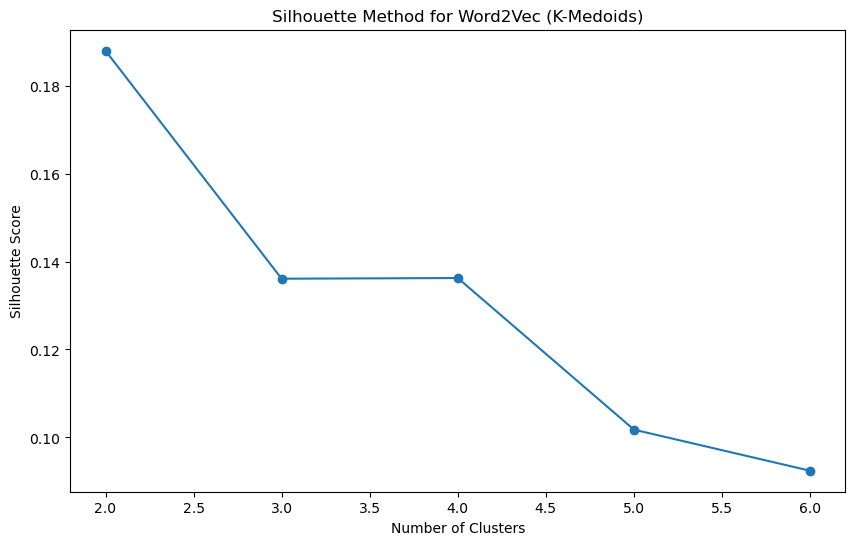

In [18]:
silhouette_scores_word2vec_kmedoids = []
best_num_clusters_word2vec = -1
best_silhouette_score_word2vec = -1
num_clusters_range = range(2, 7)

for num_clusters in num_clusters_range:
    kmedoids_word2vec = KMedoids(n_clusters=num_clusters, random_state=42, metric='manhattan')
    cluster_labels_kmedoids_word2vec = kmedoids_word2vec.fit_predict(document_embeddings)
    silhouette_score_word2vec = silhouette_score(document_embeddings, cluster_labels_kmedoids_word2vec)
    silhouette_scores_word2vec_kmedoids.append(silhouette_score_word2vec)
    
    if silhouette_score_word2vec > best_silhouette_score_word2vec:
        best_silhouette_score_word2vec = silhouette_score_word2vec
        best_num_clusters_word2vec = num_clusters

# Plotting the Silhouette scores for Word2Vec with K-Medoids
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores_word2vec_kmedoids, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Word2Vec (K-Medoids)')
plt.show()

best_num_clusters_kmedoids_word2vec = np.argmax(silhouette_scores_word2vec_kmedoids) + 2
best_silhouette_score_kmedoids_word2vec = silhouette_scores_word2vec_kmedoids[np.argmax(silhouette_scores_word2vec_kmedoids)]



#### TF-IDF & K-Medoids

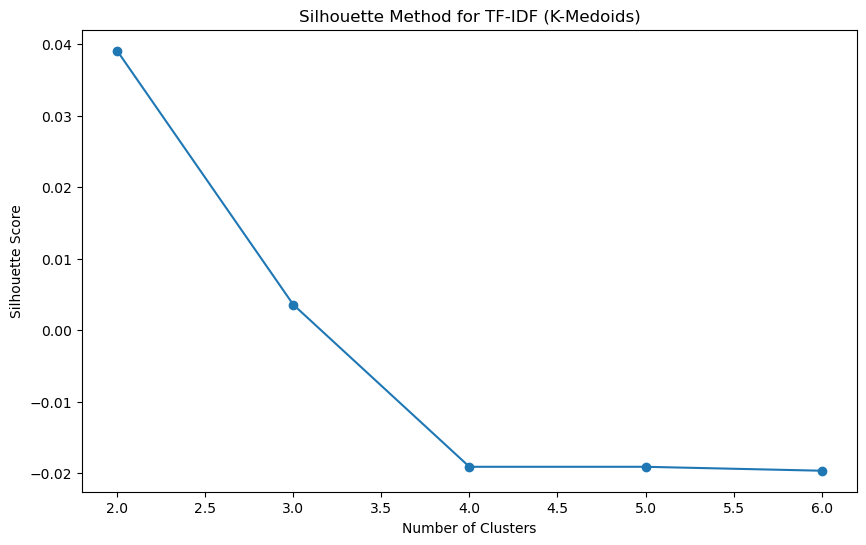

In [19]:
silhouette_scores_tfidf_kmedoids = []
best_num_clusters_tfidf = -1
best_silhouette_score_tfidf = -1

num_clusters_range = range(2, 7)  

for num_clusters in num_clusters_range:
    kmedoids_tfidf = KMedoids(n_clusters=num_clusters, random_state=42, metric='manhattan')
    cluster_labels_kmedoids_tfidf = kmedoids_tfidf.fit_predict(tfidf_matrix)
    
    # Checking if there are more than 1 unique clusters
    unique_labels = np.unique(cluster_labels_kmedoids_tfidf)
    if len(unique_labels) > 1:
        silhouette_score_tfidf = silhouette_score(tfidf_matrix, cluster_labels_kmedoids_tfidf, metric='manhattan')
        silhouette_scores_tfidf_kmedoids.append(silhouette_score_tfidf)

        if silhouette_score_tfidf > best_silhouette_score_tfidf:
            best_silhouette_score_tfidf = silhouette_score_tfidf
            best_num_clusters_tfidf = num_clusters
    else:
        silhouette_scores_tfidf_kmedoids.append(-1)

#Plotting the silhouette scores for TFIDF with KMedoids
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, silhouette_scores_tfidf_kmedoids, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for TF-IDF (K-Medoids)')
plt.show()

best_num_clusters_kmedoids_tfidf = np.argmax(silhouette_scores_tfidf_kmedoids) + 2
best_silhouette_score_kmedoids_tfidf = silhouette_scores_tfidf_kmedoids[np.argmax(silhouette_scores_tfidf_kmedoids)]



In [20]:
print("Optimal number of clusters and Silhouette scores:")
print("K-Means with Word2Vec: Number of Clusters =", best_num_clusters_kmeans_word2vec, ", Silhouette Score =", best_silhouette_score_kmeans_word2vec)
print("K-Means with TF-IDF: Number of Clusters =", best_num_clusters_kmeans_tfidf, ", Silhouette Score =", best_silhouette_score_kmeans_tfidf)
print("K-Medoids with Word2Vec: Number of Clusters =", best_num_clusters_kmedoids_word2vec, ", Silhouette Score =", best_silhouette_score_kmedoids_word2vec)
print("K-Medoids with TF-IDF: Number of Clusters =", best_num_clusters_kmedoids_tfidf, ", Silhouette Score =", best_silhouette_score_kmedoids_tfidf)

Optimal number of clusters and Silhouette scores:
K-Means with Word2Vec: Number of Clusters = 2 , Silhouette Score = 0.19451813
K-Means with TF-IDF: Number of Clusters = 6 , Silhouette Score = 0.19790224075490806
K-Medoids with Word2Vec: Number of Clusters = 2 , Silhouette Score = 0.18793589
K-Medoids with TF-IDF: Number of Clusters = 2 , Silhouette Score = 0.0390751722054651


#### Best result is achieved using K-Means clustering & TF-IDF pair with 6 clusters, but K-Means & Word2Vec with 2 clusters is close 

#### So we'll plot both and compare, using PCA for dimensionality reduction



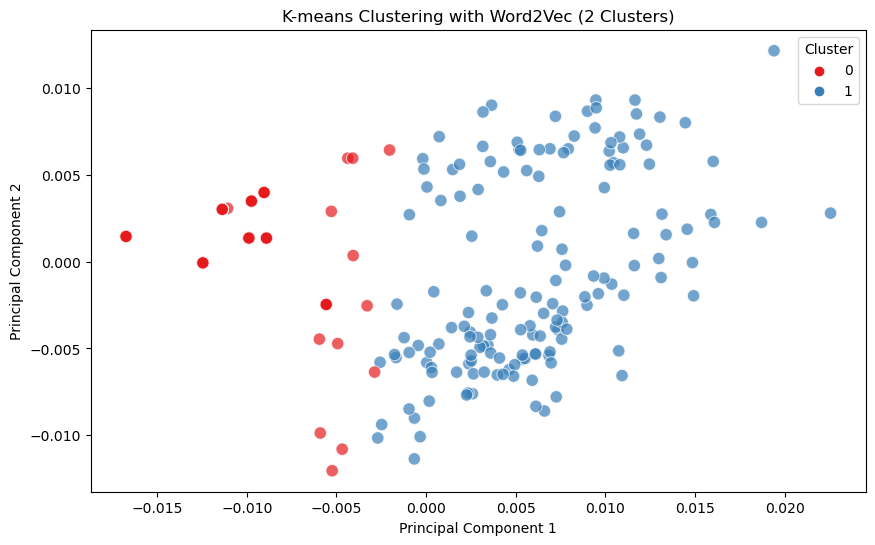

In [21]:

kmeans_word2vec = KMeans(n_clusters=2, random_state=42)
cluster_labels_word2vec = kmeans_word2vec.fit_predict(document_embeddings)

# Performing PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(document_embeddings)

# Create a DataFrame to hold the reduced embeddings and cluster labels
df_clusters = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
df_clusters['Cluster'] = cluster_labels_word2vec

# Plot the clusters in 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_clusters, palette='Set1', s=80, alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with Word2Vec (2 Clusters)')
plt.legend(title='Cluster', loc='upper right')
plt.show()

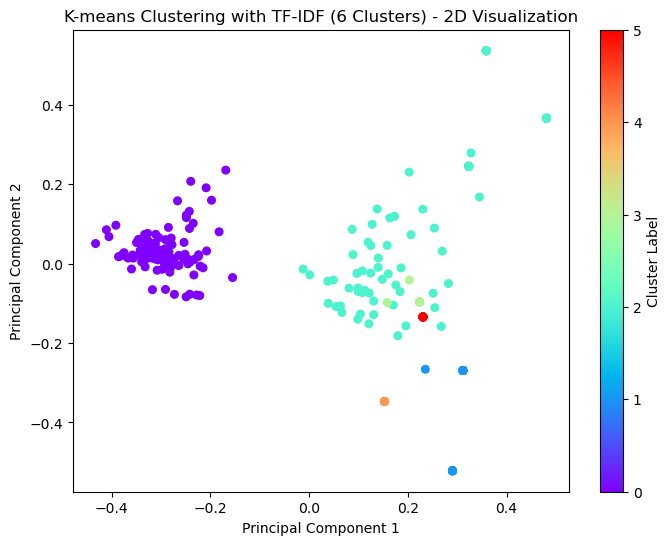

In [22]:
kmeans_tfidf = KMeans(n_clusters=6, random_state=42)
cluster_labels_tfidf = kmeans_tfidf.fit_predict(tfidf_matrix)

# PCA
pca = PCA(n_components=2)
document_embeddings_2d = pca.fit_transform(tfidf_matrix.toarray())

# Plotting the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(document_embeddings_2d[:, 0], document_embeddings_2d[:, 1], c=cluster_labels_tfidf, cmap='rainbow', s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering with TF-IDF (6 Clusters) - 2D Visualization')
plt.colorbar(label='Cluster Label')
plt.show()

#### TF-IDF seems to separate the Data into primarily 2 very distinct clusters, but then also has 4 additional clusters having less than 4 elements each.
#### Final choice should depend on business case and context of dataset provided. 
#### But given the small size of the dataset (274 rows) and ease of explainability I would opt for the 2 cluster model